## Cloth Classification Task
8 classes

In [2]:
import os
import torch
import time
import copy
import pandas as pd
import numpy as np
import random
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


## Visualize Data

In [3]:
train_frame = pd.read_csv('train_label.csv')

# check one photo
img_name = train_frame.iloc[7, 0]
classes = train_frame.iloc[:, 1].as_matrix()
classes = classes.astype('float').reshape(-1, 1)

print('Image name: {}'.format(img_name))
print('classes shape: {}'.format(classes.shape))
print('classes: {}'.format(classes[7]))

Image name: 1002906763_0.jpg
classes shape: (21048, 1)
classes: [ 0.]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


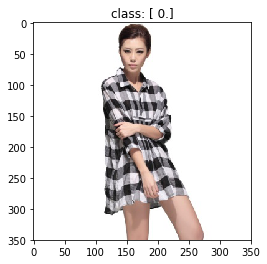

In [4]:
# show images
def show_image(images, label):
    plt.title('class: {}'.format(label))
    plt.imshow(images)
    
show_image(io.imread(os.path.join('./dataset/image/train/', img_name)), classes[7])

## Construct Dataset

In [5]:
class ClothDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, test=False):
        self.train_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.test = test
        
        if self.test:
            imgs = [os.path.join(root_dir, img) for img in os.listdir(root_dir)]
        else:
            names = self.train_frame.iloc[:, 0]
            imgs = [os.path.join(root_dir, img) for img in names]
    
        self.imgs = imgs
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        if self.test == False:
            label = self.train_frame.iloc[idx, 1]
        else:
            label = -1
            
        image = Image.open(img_path)
        image = image.convert('RGB')
        if self.transform:
            image = self.transform(image)
            
        return image, label

### Check Dataset(train)

0 0
1 0
2 0
3 0


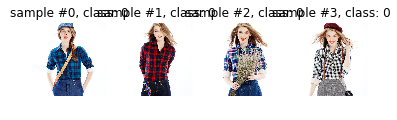

In [6]:
cloth_train_dataset = ClothDataset(csv_file='train_label.csv', root_dir='./dataset/image/train/', test=False)
fig = plt.figure()

for i in range(len(cloth_train_dataset)):
    image, label = cloth_train_dataset[i]
    
    print(i, label)
    
    ax = plt.subplot(1, 4, i + 1)
    
    ax.set_title('sample #{}, class: {}'.format(i, label))
    ax.axis('off')
    plt.imshow(image)
    
    if i == 3:
        plt.show()
        break

### Check Dataset(test)

0 -1
1 -1
2 -1
3 -1


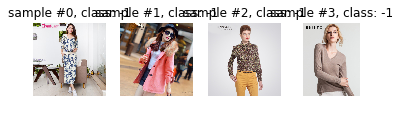

In [7]:
cloth_test_dataset = ClothDataset(csv_file='train_label.csv', root_dir='./dataset/image/test/', test=True)
fig = plt.figure()

for i in range(len(cloth_test_dataset)):
    image, label = cloth_test_dataset[i]
    
    print(i, label)
    
    ax = plt.subplot(1, 4, i + 1)
    
    ax.set_title('sample #{}, class: {}'.format(i, label))
    ax.axis('off')
    plt.imshow(image)
    
    if i == 3:
        plt.show()
        break

### Data Augmentation

In [8]:
# transform1
transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    #transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4924044, 0.47831464, 0.44143882), (0.25063434, 0.2492162,  0.26660094))
])

# transform2
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4924044, 0.47831464, 0.44143882), (0.25063434, 0.2492162,  0.26660094))
])

### Test Transformation

In [9]:
full_dataset = ClothDataset(csv_file='./train_label.csv', root_dir='./dataset/image/train/', test=False, transform=transform_train)
print(type(full_dataset[i]))
print('train_dataset size: ', len(full_dataset))

for i in range(len(full_dataset)):
    image, label = full_dataset[i]
    
    print(i, image.shape, label)
    
    if i == 3:
        break

<class 'tuple'>
train_dataset size:  21048
0 torch.Size([3, 224, 224]) 0
1 torch.Size([3, 224, 224]) 0
2 torch.Size([3, 224, 224]) 0
3 torch.Size([3, 224, 224]) 0


## 划分训练集和校验集

In [10]:
validation_split=0.2
dataset_size = len(full_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.seed(42)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Create data samples and loaders
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=30, sampler=train_sampler)
validation_dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=30, sampler=valid_sampler)

print(type(train_dataloader))
print(type(validation_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [11]:
# combine train and validation into one dict
dataloaders = {'train': train_dataloader, 'val': validation_dataloader}
dataset_sizes = {'train': len(train_indices), 'val': len(val_indices)}
print(dataset_sizes['train'])

16839


In [12]:
test_dataset = ClothDataset(csv_file='./train_label.csv', root_dir = './dataset/image/test/', test=True,transform= transform_test)
print(type(test_dataset[i]))

for i in range(len(test_dataset)):
    image, label = test_dataset[i]
    
    print(i, image.size(), label)
    
    if i == 3:
        break

<class 'tuple'>
0 torch.Size([3, 224, 224]) -1
1 torch.Size([3, 224, 224]) -1
2 torch.Size([3, 224, 224]) -1
3 torch.Size([3, 224, 224]) -1


### Show Batch Data

<class 'torch.utils.data.dataloader.DataLoader'>
0 torch.Size([30, 3, 224, 224]) tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])
1 torch.Size([30, 3, 224, 224]) tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])
2 torch.Size([30, 3, 224, 224]) tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 torch.Size([30, 3, 224, 224]) tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])


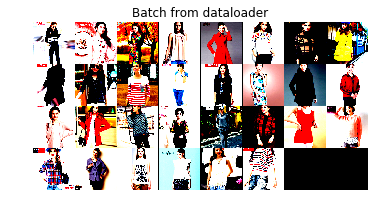

In [15]:
# use DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=30, shuffle=False)
print(type(test_dataloader))


def show_cloth_batch(images_batch, labels_batch):
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
    for i in range(batch_size):
        plt.title('Batch from dataloader')
        
for i_batch, (images_batch, labels_batch) in enumerate(test_dataloader):
    print(i_batch, images_batch.size(), labels_batch)
    
    if i_batch == 3:
        plt.figure()
        show_cloth_batch(images_batch, labels_batch)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

## Train Model

In [16]:
def show_curve(ys, title):
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y)
    plt.title("{} curve".format(title))
    plt.xlabel('epoch')
    plt.ylabel("{}".format(title))
    plt.show()

In [17]:
def save_model(model,filename):
    state = model.state_dict()
    for key in state: state[key] = state[key].clone().cpu()
    torch.save(state, filename)

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    # measure time
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and testing phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train() # train mode
            else:
                model.eval() # evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # iterate over data
            for i_batch, (images_batch, labels_batch) in enumerate(dataloaders[phase]):
                #print(type(sample_batched['image']))
                #print(type(sample_batched['has_cactus']))
                
                inputs = images_batch.to(device, dtype=torch.float)
                labels = labels_batch.to(device, dtype=torch.long)
                
                # labels = labels.resize(labels.size()[0])
                #print(labels.size())
                #print(labels)
                
                # zero gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #print(outputs.size())
                    #print(labels.size())
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistic
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            #print(running_loss)
            #print(running_corrects)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # save best model weights up-to-date
                save_model(model, './model/resnet50_new_BEST.pt')
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    show_curve(train_loss, 'train_loss')
    show_curve(train_acc, 'train_acc')
    show_curve(val_loss, 'val_loss')
    show_curve(val_acc, 'val_acc')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualize Model Prediction

In [19]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [20]:
# Visualize the model predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i_batch, (images_batch, labels_batch) in enumerate(dataloaders['val']):
            # Move to GPU
            inputs = images_batch.to(device, dtype=torch.float)
            labels = labels_batch.to(device, dtype=torch.long)
            # labels = labels.resize(labels.size()[0])
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                # show images
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predict: {}'.format(preds[j].item()))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
            model.train(mode=was_training)

## Set Hyper-parameter

In [22]:
# Set Model
model_resnet50 = models.resnet50(pretrained=True)
print(model_resnet50)
num_ftrs = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_ftrs, 8)


# Set Parameters
lr = 0.001
momentum = 0.9
step_size=10
gamma=0.1
num_epochs=20

# Set GPU
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

### resnet50

In [23]:
model = model_resnet50.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Epoch 0/19
----------
train Loss: 0.7412 Acc: 0.7465
val Loss: 0.3964 Acc: 0.8603

Epoch 1/19
----------
train Loss: 0.3867 Acc: 0.8656
val Loss: 0.3719 Acc: 0.8686

Epoch 2/19
----------
train Loss: 0.2991 Acc: 0.8983
val Loss: 0.3587 Acc: 0.8772

Epoch 3/19
----------
train Loss: 0.2428 Acc: 0.9175
val Loss: 0.3738 Acc: 0.8757

Epoch 4/19
----------
train Loss: 0.2045 Acc: 0.9307
val Loss: 0.4087 Acc: 0.8760

Epoch 5/19
----------
train Loss: 0.1732 Acc: 0.9420
val Loss: 0.3811 Acc: 0.8883

Epoch 6/19
----------
train Loss: 0.1472 Acc: 0.9492
val Loss: 0.3986 Acc: 0.8817

Epoch 7/19
----------
train Loss: 0.1145 Acc: 0.9595
val Loss: 0.4194 Acc: 0.8786

Epoch 8/19
----------
train Loss: 0.0971 Acc: 0.9669
val Loss: 0.4147 Acc: 0.8841

Epoch 9/19
----------
train Loss: 0.0872 Acc: 0.9699
val Loss: 0.4431 Acc: 0.8833

Epoch 10/19
----------
train Loss: 0.0536 Acc: 0.9830
val Loss: 0.4219 Acc: 0.8907

Epoch 11/19
----------
train Loss: 0.0455 Acc: 0.9862
val Loss: 0.4190 Acc: 0.8914

Ep

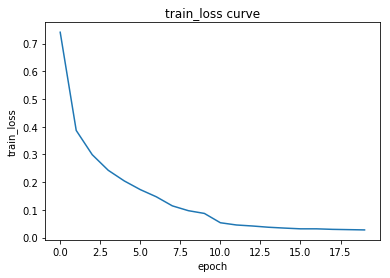

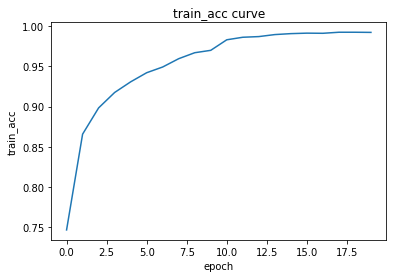

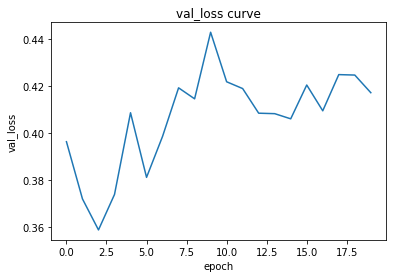

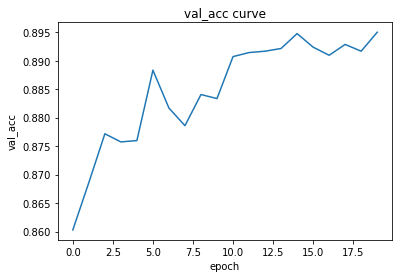

In [24]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

### resnet101

In [40]:
model = model_resnet101.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Epoch 0/29
----------
train Loss: 0.7001 Acc: 0.7614
val Loss: 0.3871 Acc: 0.8686

Epoch 1/29
----------
train Loss: 0.3622 Acc: 0.8785
val Loss: 0.4269 Acc: 0.8572

Epoch 2/29
----------
train Loss: 0.2728 Acc: 0.9071
val Loss: 0.3677 Acc: 0.8767

Epoch 3/29
----------
train Loss: 0.2113 Acc: 0.9300
val Loss: 0.3367 Acc: 0.8893

Epoch 4/29
----------
train Loss: 0.1755 Acc: 0.9403
val Loss: 0.3935 Acc: 0.8793

Epoch 5/29
----------
train Loss: 0.1375 Acc: 0.9546
val Loss: 0.3909 Acc: 0.8833

Epoch 6/29
----------
train Loss: 0.1077 Acc: 0.9634
val Loss: 0.4083 Acc: 0.8867

Epoch 7/29
----------
train Loss: 0.0913 Acc: 0.9700
val Loss: 0.4414 Acc: 0.8779

Epoch 8/29
----------
train Loss: 0.0790 Acc: 0.9733
val Loss: 0.4199 Acc: 0.8864

Epoch 9/29
----------
train Loss: 0.0633 Acc: 0.9806
val Loss: 0.4494 Acc: 0.8852

Epoch 10/29
----------
train Loss: 0.0372 Acc: 0.9895
val Loss: 0.4321 Acc: 0.8919

Epoch 11/29
----------
train Loss: 0.0314 Acc: 0.9906
val Loss: 0.4291 Acc: 0.8928

Ep

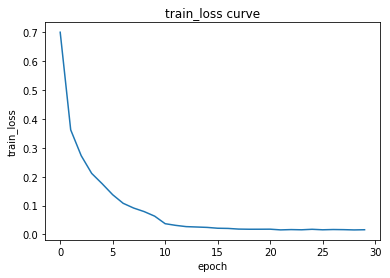

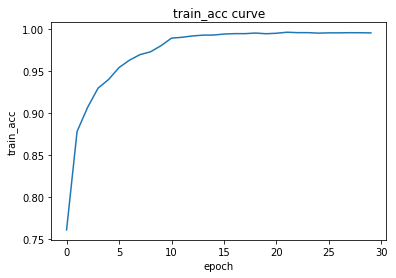

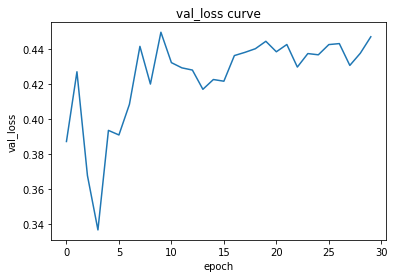

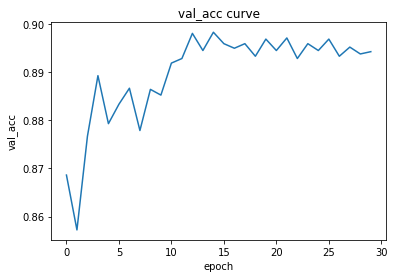

In [41]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

### resnet152

In [59]:
model = model_resnet152.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Epoch 0/29
----------
train Loss: 0.6871 Acc: 0.7691
val Loss: 0.4271 Acc: 0.8517

Epoch 1/29
----------
train Loss: 0.3449 Acc: 0.8854
val Loss: 0.3447 Acc: 0.8793

Epoch 2/29
----------
train Loss: 0.2590 Acc: 0.9128
val Loss: 0.3314 Acc: 0.8857

Epoch 3/29
----------
train Loss: 0.1960 Acc: 0.9354
val Loss: 0.3613 Acc: 0.8812

Epoch 4/29
----------
train Loss: 0.1631 Acc: 0.9454
val Loss: 0.3507 Acc: 0.8893

Epoch 5/29
----------
train Loss: 0.1218 Acc: 0.9596
val Loss: 0.3748 Acc: 0.8886

Epoch 6/29
----------
train Loss: 0.1031 Acc: 0.9663
val Loss: 0.4502 Acc: 0.8689

Epoch 7/29
----------
train Loss: 0.0832 Acc: 0.9714
val Loss: 0.4141 Acc: 0.8917

Epoch 8/29
----------
train Loss: 0.0662 Acc: 0.9776
val Loss: 0.4628 Acc: 0.8867

Epoch 9/29
----------
train Loss: 0.0649 Acc: 0.9781
val Loss: 0.4354 Acc: 0.8886

Epoch 10/29
----------
train Loss: 0.0376 Acc: 0.9885
val Loss: 0.3995 Acc: 0.8938

Epoch 11/29
----------
train Loss: 0.0294 Acc: 0.9917
val Loss: 0.4120 Acc: 0.8978

Ep

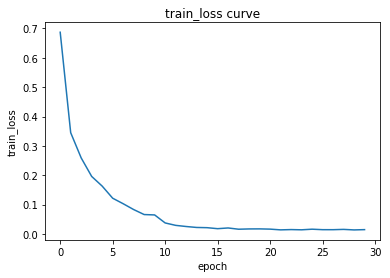

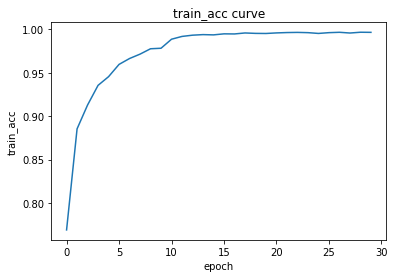

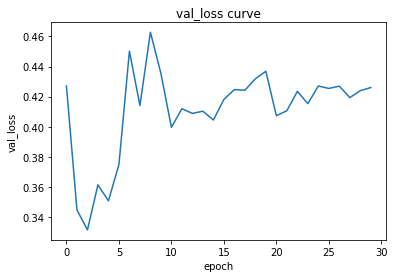

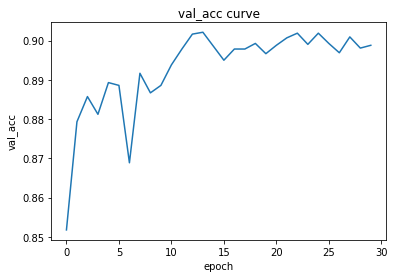

In [60]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

### ResNeXt-101-32x8d

## Predict

In [61]:
def predict(model, test_dataloader):
    result = []
    with torch.no_grad():
         for i_batch, (images_batch, labels_batch) in enumerate(test_dataloader):
            # Move to GPU
            inputs = images_batch.to(device, dtype=torch.float)
            labels = labels_batch.to(device, dtype=torch.long)
            # labels = labels.resize(labels.size()[0])
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            
            # print(type(preds))
            # print(preds)
            preds_np = preds.cpu().numpy()
            # print(preds_np)
            result = np.append(result, preds_np)
            
            # print(result)
            
            if (i_batch == 2000):
                print('2000 batches')
            elif i_batch == 4000:
                print('4000 batches')
    
    return result

In [63]:
# Set Model
model_resnet152 = models.resnet152(pretrained=True)
num_ftrs = model_resnet152.fc.in_features
model_resnet152.fc = nn.Linear(num_ftrs, 8)
checkpoint = torch.load('./model/resnet152_new_BEST.pt')
model_resnet152.load_state_dict(checkpoint)

model = model_resnet152.to(device)

In [64]:
result = predict(model, test_dataloader)

In [65]:
print(type(result))
print(result.shape)

<class 'numpy.ndarray'>
(4500,)


In [66]:
img_idx = os.listdir('./dataset/image/test/')
print(img_idx)
img_idx = prediction.iloc[:, 0]
print(img_idx)

['1257194670_0.jpg', '1331669067_0.jpg', '1030031690_0.jpg', '1042079939_0.jpg', '1392549927_0.jpg', '1219369112_0.jpg', '1074414124_0.jpg', '1022435684_0.jpg', '1382318481_0.jpg', '1109736123_0.jpg', '1049622193_0.jpg', '1029862130_0.jpg', '1445565607_0.jpg', '1454956234_0.jpg', '1004558638_0.jpg', '1477572864_0.jpg', '1797314050_0.jpg', '1054664399_0.jpg', '1087983100_0.jpg', '1156694115_0.jpg', '1187166366_0.jpg', '1344869062_0.jpg', '1411108444_0.jpg', '1500368012_0.jpg', '1111112171_0.jpg', '1166941378_0.jpg', '1246367092_0.jpg', '1350177495_0.jpg', '10056013380_0.jpg', '1121574657_0.jpg', '1303850620_0.jpg', '1102712669_0.jpg', '1205757170_0.jpg', '1036523237_0.jpg', '1324702294_0.jpg', '1392129959_0.jpg', '1359907332_0.jpg', '1478486268_0.jpg', '1389461157_0.jpg', '1095502819_0.jpg', '1722904135_0.jpg', '1029194300_0.jpg', '1539907962_0.jpg', '1409573292_0.jpg', '1485571905_0.jpg', '1146838255_0.jpg', '1101318621_0.jpg', '1314149812_0.jpg', '1146567724_0.jpg', '1262301524_0.jpg'

NameError: name 'prediction' is not defined

In [67]:
classify_result = pd.DataFrame({'Image': img_idx, 'Cloth_label': result.astype(np.int32)})
print(classify_result)

                  Image  Cloth_label
0      1257194670_0.jpg            5
1      1331669067_0.jpg            6
2      1030031690_0.jpg            0
3      1042079939_0.jpg            7
4      1392549927_0.jpg            7
5      1219369112_0.jpg            7
6      1074414124_0.jpg            7
7      1022435684_0.jpg            4
8      1382318481_0.jpg            7
9      1109736123_0.jpg            5
10     1049622193_0.jpg            3
11     1029862130_0.jpg            2
12     1445565607_0.jpg            4
13     1454956234_0.jpg            6
14     1004558638_0.jpg            1
15     1477572864_0.jpg            4
16     1797314050_0.jpg            0
17     1054664399_0.jpg            5
18     1087983100_0.jpg            4
19     1156694115_0.jpg            5
20     1187166366_0.jpg            1
21     1344869062_0.jpg            7
22     1411108444_0.jpg            3
23     1500368012_0.jpg            5
24     1111112171_0.jpg            1
25     1166941378_0.jpg            1
2

In [68]:
classify_result.to_csv('./result/result_resnet152.csv', index=False)